# Part 2: other environments and RL training
---

In this notebook we will go over some of the variations of `greenCrabEnv` available in this package, and over the syntax for training RL algorithms on instances of these environments.

## 0. Setup
---
As with Part 1 of this series, uncomment the following cell in order to install our package if you haven't done so already. After that restart the jupyter kernel.

In [3]:
%pip install -e ..

Obtaining file:///home/rstudio/rl4greencrab
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for rl4greencrab (pyproject.toml) ... done
  Created wheel for rl4greencrab: filename=rl4greencrab-1.0.0-py2.py3-none-any.whl size=1073 sha256=b125839fccc41947614acd0fb477a4cd383c45dfc4c4d3f62424b7ba0fe2f36b
  Stored in directory: /tmp/pip-ephem-wheel-cache-dnq6ee9u/wheels/01/b3/9b/f19820538b59bf2d6fff135754c44d6024c68184a6dac19b71
Successfully built rl4greencrab
  Attempting uninstall: rl4greencrab
    Found existing installation: rl4greencrab 1.0.0
    Uninstalling rl4greencrab-1.0.0:
      Successfully uninstalled rl4greencrab-1.0.0
Note: you may need to restart the kernel to use updated packages.


In [5]:
import numpy as np
import pandas as pd
from plotnine import ggplot, aes, geom_density, geom_line, geom_point, geom_violin, facet_grid, labs, theme, facet_wrap

from stable_baselines3 import PPO, TD3
from sb3_contrib import TQC
from stable_baselines3.common.env_util import make_vec_env

from rl4greencrab import greenCrabSimplifiedEnv, simulator
from huggingface_hub import hf_hub_download

## 1. Other envs
---

We will go over two other envs provided by our package: `greenCrabSimplifiedEnv` and `timeSeriesEnv`.
Let's focus on the first one of these envs.

### greenCrabSimplifiedEnv

`greenCrabSimplifiedEnv` is closely related to `greenCrabEnv` and only varies in small aspects.
Let's examine these aspecs one by one.
The first aspect is its action space:

In [2]:
gcse = greenCrabSimplifiedEnv()
gcse.action_space

Box(-1.0, 1.0, (3,), float32)

Actions in this `greenCrabSimplifiedEnv` are between -1 and +1 (in contrast to `greenCrabEnv` where they were in [0, 2000]). 
This difference in action space is purely conceptual: we linearly associate the segment [-1, 1] to the segment [0, 2000] so that, e.g., an action of -1 corresponds to 0 traps laid, an action of 0 corresponds to 1000 traps laid, and an action of +1 corresponds to 2000 traps laid.
Mathematically, this transformation is:
$$a = A / 1000 - 1$$,
where $A\in[0,2000]$ and $a\in[-1,1]$.
This transformation of action space is performed because of purely computational reasons related to hyperparameter tuning of RL algorithms.

A second difference of `greenCrabSimplifiedEnv` with respect to `greenCrabEnv` is in its observation space.

In [3]:
gcse.observation_space

Box(-1.0, 1.0, (2,), float32)

In [4]:
gcse.reset()

(array([-1., -1.], dtype=float32), {})

Here, observations are vectors with *three* components instead of nine, and they are [-1, 1] valued.
E.g., consider the following observation after a second time-step:

In [7]:
gcse.step(np.float32([-0.5, -0.5, -0.5]))[0], gcse.step(np.float32([-0.5, -0.5, -0.5]))[0], gcse.step(np.float32([-0.5, -0.5, -0.5]))[0]

(array([-0.99992, -0.99972], dtype=float32),
 array([-0.99908, -0.99896], dtype=float32),
 array([-0.99752, -0.99696], dtype=float32))

These three numbers correspond to: 1. the catch per 100 traps in the first five months of the year, 2. the catch per 100 traps in the later four months of the year, 3. the number of traps.
These three numbers are transformed to [-1, 1] in a similar fashion to eq. (1).

This simplifies the observations, making it easier for RL algorithms to exploit the information they provide.
Because of this, we will train our algorithms on `greenCrabSimplifiedEnv` rather than `greenCrabEnv`.

### timeSeriesEnv

TBD.

## 2. Training and evaluating RL algos
---

Here we cover some basic syntax for training RL algorithms on our envs.
We use short train times for the sake of brevity in this example.
Typical run-times might need upwards of 1 million time-steps, or possibly up to 10 million time-steps to converge.
This number will, however, depend on the particular algorithm used.

**Note:** This package also provides a more ergonomic syntax for training through the `train.py` script. 
To train models this way, run the following command on the terminal:

`python scripts/train.py -f hyperpars/ppo-gcse.yml`

There, we encode the input to the training algorithm as a YAML file.

In [3]:
config = {
        'action_reward_scale': np.array([0.08, 0.08, 0.4]),
        'max_action': 3000,
        # 'env_stoch': 0.,
        'trapm_pmax': 10 * 0.1 * 2.75e-5, #2.26e-6,
        'trapf_pmax': 10 * 0.03 * 2.75e-5, #8.3e-7,
        'traps_pmax': 10 * 2.75e-5, #2.75e-5,

        'loss_a': 0.2,
        'loss_b': 5,
        'loss_c': 5,
        
        'action_reward_exponent': 10,
    }

In [4]:
gcse = greenCrabSimplifiedEnv(config)
vec_env = make_vec_env(greenCrabSimplifiedEnv, n_envs=12)

### PPO

In [13]:
model = PPO("MlpPolicy", vec_env, verbose=0, tensorboard_log="/home/rstudio/logs")
model.learn(
	total_timesteps=250_000, 
	progress_bar=True,
)
model.save("ppo_gcse")

Output()

### TD3

In [20]:
model = TD3("MlpPolicy", gcse, verbose=0, tensorboard_log="/home/rstudio/logs")
model.learn(
	total_timesteps=250_000, 
	progress_bar=True,
)
model.save("td3_gcse")

Output()

### TQC

In [21]:
model = TQC("MlpPolicy", vec_env, verbose=0, tensorboard_log="/home/rstudio/logs")
model.learn(
	total_timesteps=250_000, 
	progress_bar=True,
)
model.save("tqc_gcse")

Output()

## 3. Loading and evaluating RL algos
---

### load from HuggingFace

In [15]:
repo_id = "jimjiang203/greencrabPPO"
ppo_path = hf_hub_download(repo_id=repo_id, filename="ppo_gcse_short.zip")
td3_path = hf_hub_download(repo_id=repo_id, filename='td3_gcse_short.zip')

td3_gcse_short.zip:   0%|          | 0.00/5.94M [00:00<?, ?B/s]

In [16]:
ppoAgent = PPO.load(ppo_path)
td3Agent = TD3.load(td3_path)
tqcAgent = TQC.load("tqc_gcse")
evalEnv = greenCrabSimplifiedEnv(config)

/opt/conda/lib/python3.11/site-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object clip_range. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
/opt/conda/lib/python3.11/site-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int


In [8]:
from stable_baselines3.common.evaluation import evaluate_policy

### PPO

In [11]:
mean_rew, std_rew = evaluate_policy(ppoAgent, evalEnv)
print(f"PPO reward = {mean_rew:.5f} +/- {std_rew:.5f}")

PPO reward = -0.00063 +/- 0.00000


### TD3

In [17]:
mean_rew, std_rew = evaluate_policy(td3Agent, evalEnv)
print(f"TD3 reward = {mean_rew:.5f} +/- {std_rew:.5f}")

/opt/conda/lib/python3.11/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.


TD3 reward = -0.00151 +/- 0.00000


### TQC

In [7]:
mean_rew, std_rew = evaluate_policy(tqcAgent, evalEnv)
print(f"TQC reward = {mean_rew:.5f} +/- {std_rew:.5f}")

TQC reward = -0.47400 +/- 0.00035


## 4. Timeseries of episodes
---

### PPO

In [12]:
ppoData = simulator(env = evalEnv, agent = ppoAgent).simulate_full_named_obs_acts()
ppoDataDF = pd.DataFrame(ppoData)
ppoDataDF.head()

,t,obs0,obs1,act0,act1,act2,rew,rep
0,0,-1.000000,-1.000000,-1.0,-1.0,-0.488460,0.000000,0
1,1,-1.000000,-1.000000,-1.0,-1.0,-0.488460,-0.000005,0
2,2,-0.999870,-0.998228,-1.0,-1.0,-0.488452,-0.000010,0
3,3,-0.995543,-0.992728,-1.0,-1.0,-0.488412,-0.000014,0
4,4,-0.988298,-0.988819,-1.0,-1.0,-0.488365,-0.000019,0


<Axes: xlabel='t'>

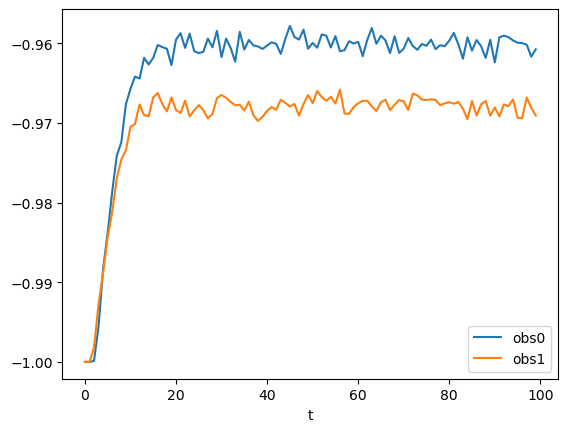

In [13]:
ppoDataDF[ppoDataDF.rep == 0].plot(x='t', y =['obs0', 'obs1'])

<Axes: xlabel='t'>

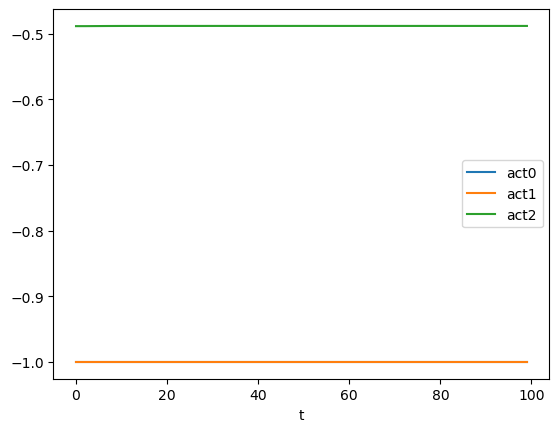

In [14]:
ppoDataDF[ppoDataDF.rep == 0].plot(x='t', y =['act0', 'act1', 'act2'])

### TD3

(<Axes: xlabel='t'>, <Axes: xlabel='t'>)

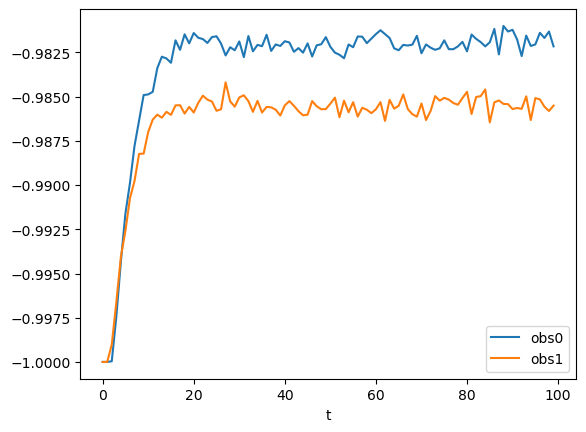

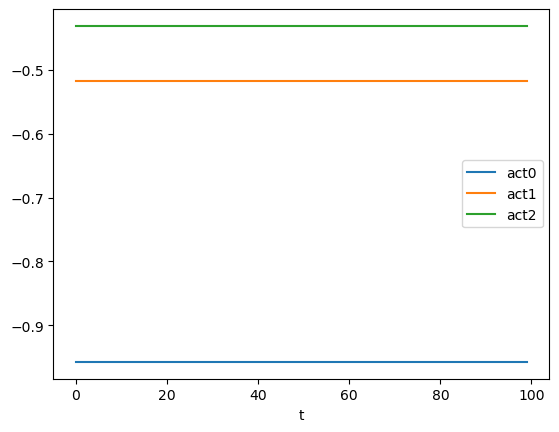

In [20]:
td3Data = simulator(env = evalEnv, agent = td3Agent).simulate_full_named_obs_acts()
td3DataDF = pd.DataFrame(td3Data)
(
    td3DataDF[td3DataDF.rep == 0].plot(x='t', y =['obs0', 'obs1']),
    td3DataDF[td3DataDF.rep == 0].plot(x='t', y =['act0','act1','act2']),
)